# Car Price Prediction

# 0.&nbsp;Connect to G-drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
default_dir = "/content/drive/MyDrive/Final Project"
os.chdir(default_dir)

In [ ]:
!ls

 best_model_Lasso.pkl		       model_Lasso.pkl
 best_model_LightGBM.pkl	       model_LGBM.pkl
 best_model_RandomForest_Default.pkl   model_LightGBM_Default.pkl
 best_model_RandomForest.pkl	       model_LightGBM.pkl
 best_model_RF.pkl		       model_price_mean.json
 best_model_Ridge.pkl		       model_RandomForest_Default.pkl
 car_price_prediction.csv	       model_RandomForest.pkl
 catboost_info			       model_RF.pkl
'List model'			       model_Ridge.pkl
 model_CatBoost_Default.pkl	       model_XGBoost_Default.pkl
 model_DecisionTree_Default.pkl        model_XGBoost.pkl
 model_DecisionTree.pkl		       model_XGB.pkl


## 0.1 mport Library

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score

# Models
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

## 0.1.&nbsp;Load Dataset

In [ ]:
df = pd.read_csv("car_price_prediction.csv")
df.drop_duplicates(inplace=True)

# 1.&nbsp;Data Understanding

In [ ]:
df.sample(5)

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
18251,45766391,1568,2018,TOYOTA,Tundra,2015,Jeep,Yes,Petrol,5.7,128000 km,8.0,Automatic,4x4,04-May,Left wheel,White,12
4457,45801394,6800,-,OPEL,Corsa Corsa,2003,Hatchback,No,Petrol,1.2,234313 km,4.0,Manual,Front,04-May,Left wheel,Silver,4
10479,45774305,22894,1723,KIA,Sorento,2018,Sedan,Yes,Petrol,3.3,49646 km,6.0,Automatic,Front,04-May,Left wheel,Grey,12
2267,45802220,41886,1091,HYUNDAI,H1,2016,Minivan,Yes,Diesel,2.5,104697 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
12999,45815952,1646,585,HYUNDAI,Elantra,2013,Sedan,Yes,Petrol,1.8,114510 km,4.0,Automatic,Front,04-May,Left wheel,Black,12


In [ ]:
print("Shape:", df.shape)

Shape: (18924, 18)


In [ ]:
print("Columns:", df.columns.tolist())

Columns: ['ID', 'Price', 'Levy', 'Manufacturer', 'Model', 'Prod. year', 'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Mileage', 'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color', 'Airbags']


In [ ]:
print(df.dtypes)

ID                    int64
Price                 int64
Levy                 object
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage              object
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags               int64
dtype: object


In [ ]:
print("\nMissing values:\n", df.isnull().sum())


Missing values:
 ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64


In [ ]:
# Temukan entri mencurigakan
df[df['Manufacturer'].str.contains("ADA", na=False)]

# Atau bersihkan entri asing/non-alfabet
df['Manufacturer'] = df['Manufacturer'].apply(lambda x: x if x.isascii() else "UNKNOWN")

In [ ]:
top_1_percent = df[df['Price'] > df['Price'].quantile(0.99)]
print(top_1_percent[['Manufacturer', 'Model', 'Price']].sort_values(by='Price', ascending=False).head(10))

        Manufacturer                    Model     Price
16983           OPEL                    Combo  26307500
8541     LAMBORGHINI                     Urus    872946
1225   MERCEDES-BENZ           G 65 AMG 63AMG    627220
5008         PORSCHE                      911    308906
14839     LAND ROVER        Range Rover Vogue    297930
9367   MERCEDES-BENZ                 AMG GT S    297930
7749             BMW  M5 Машина в максимально    288521
10759          LEXUS                   LX 570    260296
5840   MERCEDES-BENZ            GLE 400 A M G    254024
15283  MERCEDES-BENZ                  GLE 400    250574


In [ ]:
if 'ID' in df.columns or 'Id' in df.columns:
    df.drop(columns=[col for col in ['ID', 'Id'] if col in df.columns], inplace=True)

# 2.&nbsp;Exploratory Data Analysis

## 2.1 Target distribution

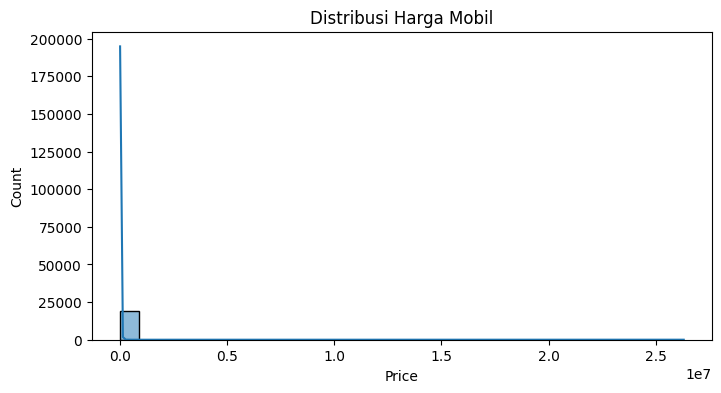

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(df['Price'], kde=True, bins=30)
plt.title('Distribusi Harga Mobil')
plt.xlabel('Price')
plt.show()

## 2.2 Correlation Matrix

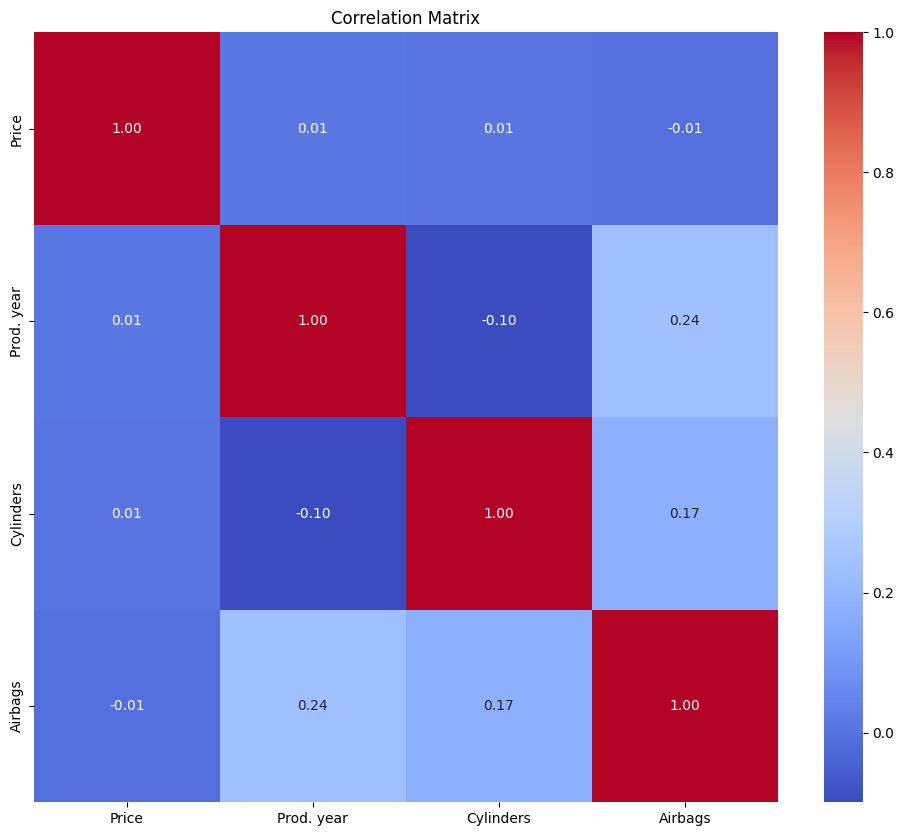

In [ ]:
plt.figure(figsize=(12, 10))
corr = df.select_dtypes(include=np.number).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## 2.3 Correlation with Price only

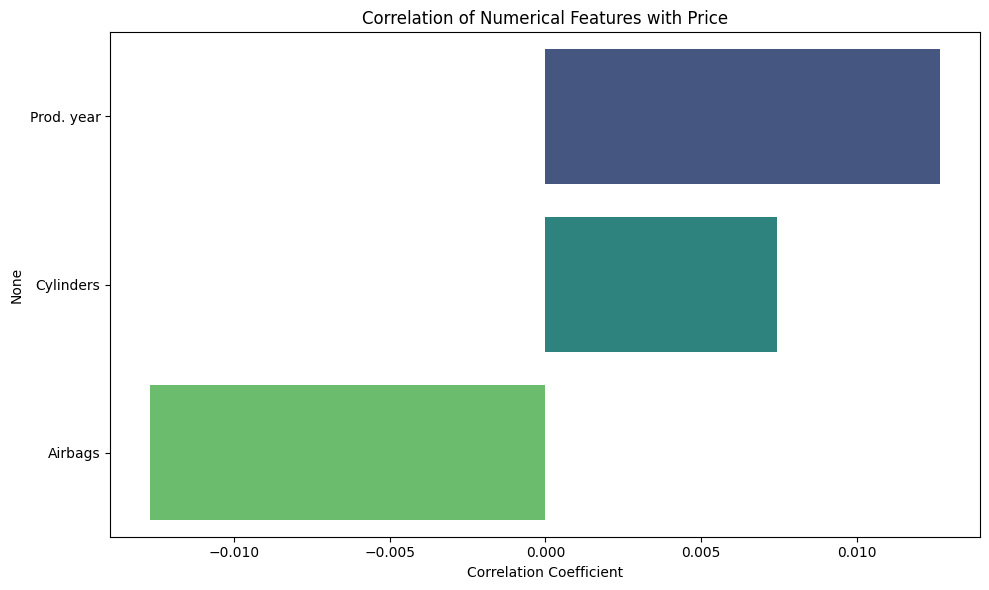

In [ ]:
plt.figure(figsize=(10, 6))
price_corr = corr['Price'].drop('Price').sort_values(ascending=False)
sns.barplot(x=price_corr.values, y=price_corr.index, palette='viridis')
plt.title('Correlation of Numerical Features with Price')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

## 2.4 Scatterplots

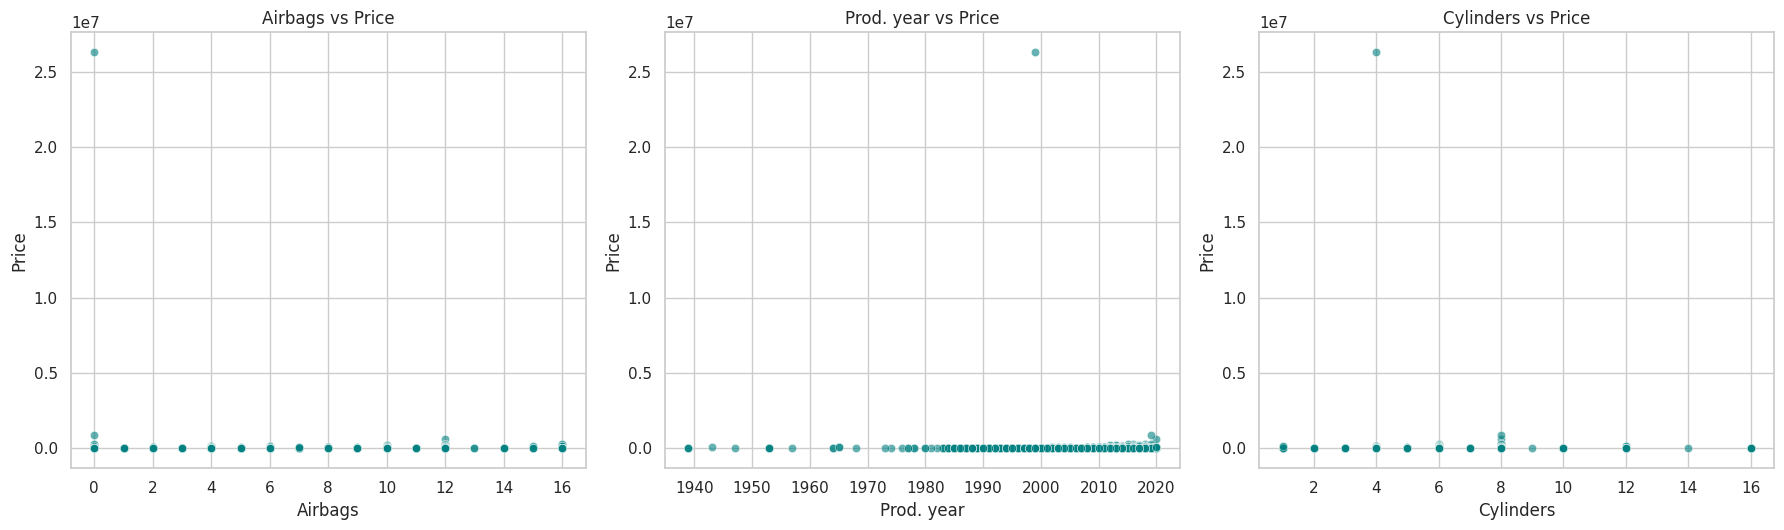

In [ ]:
top_corr_features = price_corr.abs().sort_values(ascending=False).head(5).index.tolist()

sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(top_corr_features):
    sns.scatterplot(data=df, x=col, y='Price', ax=axes[i], alpha=0.6, color='teal')
    axes[i].set_title(f'{col} vs Price')

for j in range(len(top_corr_features), len(axes)):
    fig.delaxes(axes[j])  # remove unused subplots

plt.tight_layout()
plt.show()

## 2.5 Boxplot kategori vs target

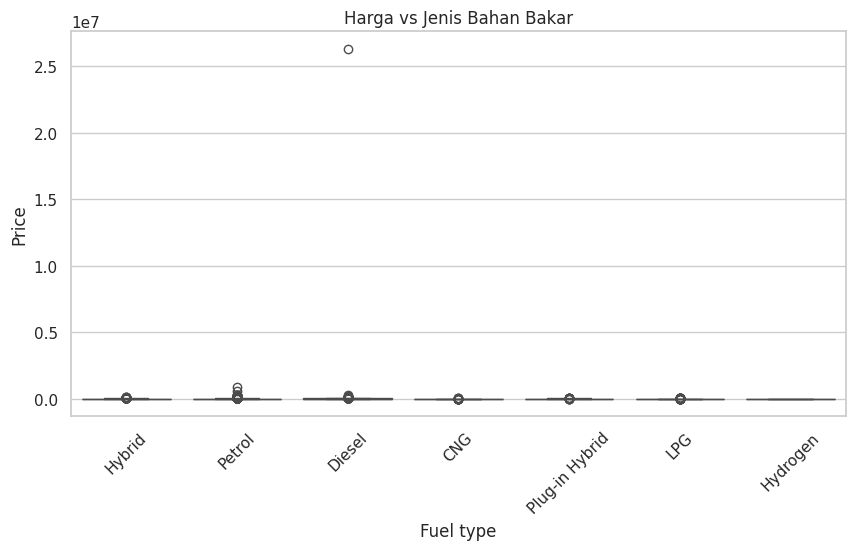

In [ ]:
if 'Fuel type' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x='Fuel type', y='Price')
    plt.title('Harga vs Jenis Bahan Bakar')
    plt.xticks(rotation=45)
    plt.show()

## 2.6 Top 25 Average Car Price by Manufacturer

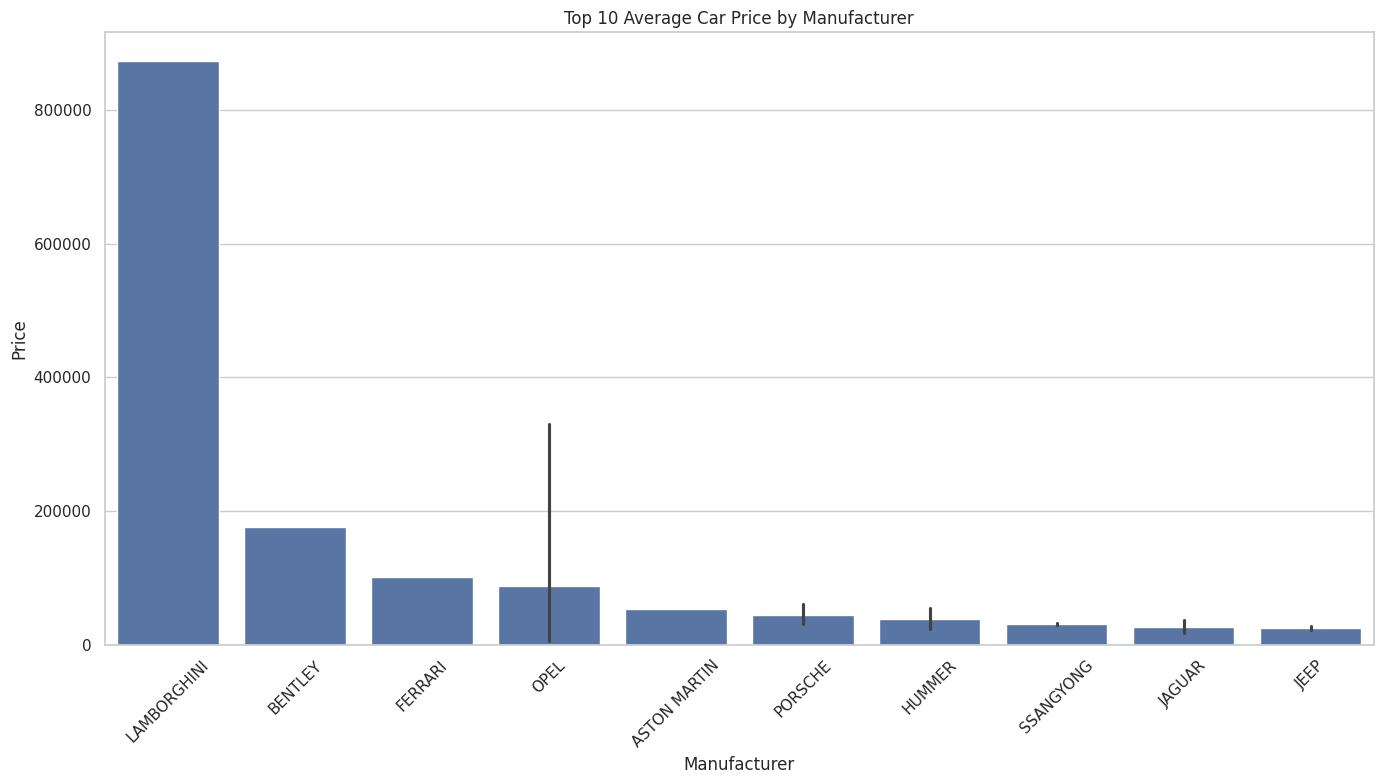

In [ ]:
plt.figure(figsize=(14, 8))

# Ambil rata-rata harga per Manufacturer dan urutkan
manufacturer_order = (
    df.groupby('Manufacturer')['Price']
    .mean()
    .sort_values(ascending=False)
    .head(10)  # ambil hanya 10 tertinggi
    .index
)

# Plot hanya data dengan manufacturer di top 10
sns.barplot(
    data=df[df['Manufacturer'].isin(manufacturer_order)],
    x='Manufacturer',
    y='Price',
    order=manufacturer_order
)

plt.title('Top 10 Average Car Price by Manufacturer')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3.&nbsp;Data Preprocessing

## 3.1 Convert Numeric Column

In [ ]:
df['Levy'] = df['Levy'].replace('-', np.nan).astype(float)
df['Levy'].fillna(df['Levy'].median(), inplace=True)
df['Mileage'] = df['Mileage'].astype(str).str.replace(' km', '', regex=False).str.replace(',', '').astype(float)

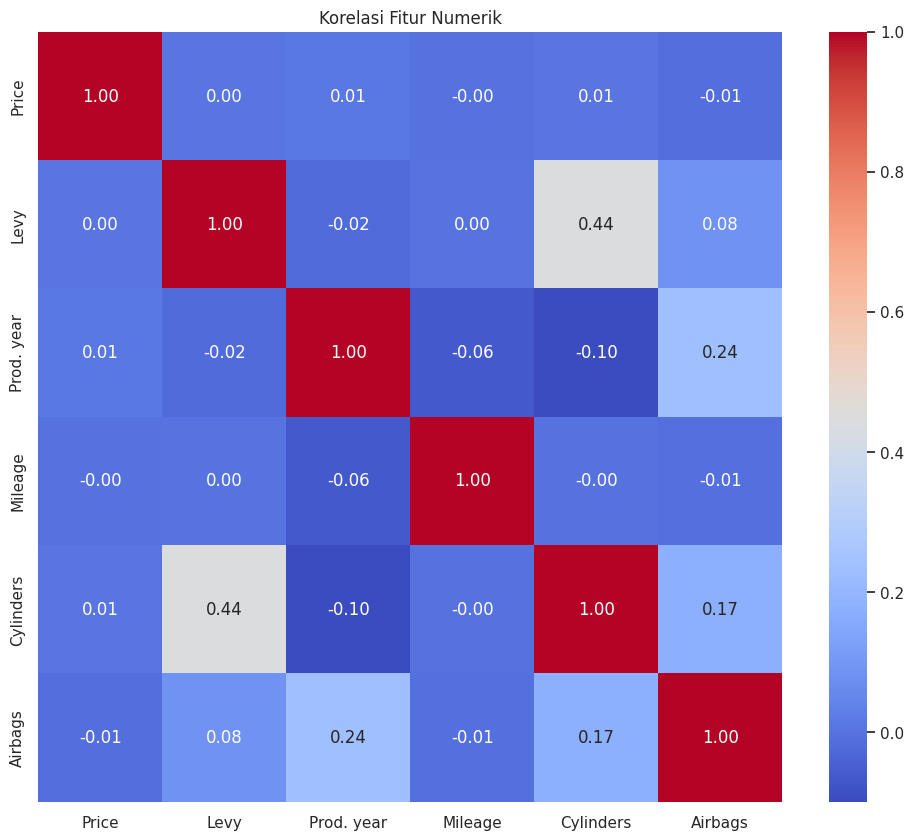

In [ ]:
plt.figure(figsize=(12, 10))
corr = df.select_dtypes(include=np.number).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Korelasi Fitur Numerik")
plt.show()

## 3.2 Drop Outlier Based On Mileage

In [ ]:
high_mileage = df['Mileage'] > 200_000
high_price = df['Price'] > df['Price'].quantile(0.75)  # harga di atas Q3
outliers_logic = df[high_mileage & high_price]

print(f"Jumlah outlier logika (Mileage tinggi dan Price mahal): {len(outliers_logic)}")
display(outliers_logic[['Model', 'Mileage', 'Price']].sort_values(by='Price', ascending=False))

Jumlah outlier logika (Mileage tinggi dan Price mahal): 434


,Model,Mileage,Price
740,S 350 W2222,222222.0,117290
10619,Combo,230000.0,103491
15031,Sprinter 516,300000.0,95000
7372,X5,260000.0,94080
15852,Sprinter 516,240000.0,87021
...,...,...,...
1466,Crafter,228000.0,22577
6867,Malibu,201612.0,22567
10126,Tucson,214639.0,22357
15125,Delica,208000.0,22266


In [ ]:
mask_not_outlier = ~((df['Mileage'] > 200_000) & (df['Price'] > df['Price'].quantile(0.75)))
df = df[mask_not_outlier]
print(f"Jumlah data setelah outlier dihapus: {len(df)}")

Jumlah data setelah outlier dihapus: 18490


## 3.3 Drop Unused Categorical Column

In [ ]:
# (Opsional) Drop 'Color' jika tidak terbukti signifikan
df.drop(columns=['Color'], inplace=True)  # opsional

## 3.4 Encode Binary Column

In [ ]:
# Ubah 'Wheel' jadi biner
df['Right_hand_drive'] = df['Wheel'].apply(lambda x: 1 if 'Right' in x else 0)
df.drop(columns=['Wheel'], inplace=True)

# Encode biner kategori
df['Leather interior'] = df['Leather interior'].map({'Yes': 1, 'No': 0})

## 3.5 Feature Engineering

In [ ]:
df['Engine volume'] = pd.to_numeric(df['Engine volume'], errors='coerce')
df['Cylinders'] = pd.to_numeric(df['Cylinders'], errors='coerce')

# Hapus baris dengan Cylinder = 0 atau NaN
df = df[df['Cylinders'] > 0]

# Cegah Engine Volume bernilai 0 atau NaN saat dibagi
df = df[df['Engine volume'] > 0]

# Buat Fitur
df['volume_per_cylinder'] = df['Engine volume'] / df['Cylinders']
# Hapus Kolom Engine volume dan Cylinders
df.drop(columns=['Engine volume'], inplace=True)
df.drop(columns=['Cylinders'], inplace=True)

df['fuel_gear'] = df['Fuel type'].astype(str) + '_' + df['Gear box type'].astype(str)
# Hapus kolom Fuel type dan Gear bot type
df.drop(columns=['Fuel type'], inplace=True)
df.drop(columns=['Gear box type'], inplace=True)

df['car_age'] = 2025 - df['Prod. year']
# Hapus Kolom Prod. year
df.drop(columns=['Prod. year'], inplace=True)

df['is_premium'] = df['Manufacturer'].isin(['BMW', 'MERCEDES-BENZ', 'AUDI', 'LEXUS']).astype(int)

model_price_mean = df.groupby("Model")["Price"].mean().to_dict()
df['Model_encoded'] = df['Model'].map(model_price_mean)
# Hapus kolom Model
df.drop(columns=['Model'], inplace=True)

In [ ]:
# Simpan mapping ke file JSON
import json
with open("model_price_mean.json", "w") as f:
    json.dump(model_price_mean, f)

## 3.6 Buat kategori Doors baru

In [ ]:
def categorize_doors(door_value):
    if door_value in ['02-Mar', '03', '2', '2-3']:
        return '2-3'
    elif door_value in ['04-May', '05', '4-5', '5']:
        return '4-5'
    elif door_value == '>5':
        return '>5'
    else:
        return 'Unknown'

df['Doors_category'] = df['Doors'].apply(categorize_doors)

In [ ]:
df.drop(columns=['Doors'], inplace=True)

## 3.7 Drop outlier khusus

In [ ]:
# Hitung batas bawah dan atas menggunakan IQR
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifikasi outlier
outliers = df[(df['Price'] < lower_bound) | (df['Price'] > upper_bound)]

# Lihat ringkasan
print("Jumlah outlier:", len(outliers))
print("Nilai minimum outlier:", outliers['Price'].min())
print("Nilai maksimum outlier:", outliers['Price'].max())

# Tampilkan beberapa contoh
print(outliers.sort_values("Price", ascending=False).head())

Jumlah outlier: 958
Nilai minimum outlier: 44457
Nilai maksimum outlier: 26307500
          Price    Levy Manufacturer     Category  Leather interior  Mileage  \
16983  26307500   781.0         OPEL  Goods wagon                 0  99999.0   
8541     872946  2067.0  LAMBORGHINI    Universal                 1   2531.0   
5008     308906  1694.0      PORSCHE        Coupe                 1   8690.0   
7749     288521  2269.0          BMW        Sedan                 1  13500.0   
4722     175622  2819.0      BENTLEY        Sedan                 1   6189.0   

      Drive wheels  Airbags  Right_hand_drive  volume_per_cylinder  \
16983        Front        0                 0             0.425000   
8541           4x4        0                 0             0.500000   
5008          Rear       12                 0             0.666667   
7749           4x4        0                 0             0.550000   
4722          Rear       12                 0             0.850000   

              fu

In [ ]:
# Tentukan batas harga masuk akal
min_price = 500
max_price = 1_500_000

# Identifikasi harga tidak masuk akal
invalid_prices = df[(df['Price'] < min_price) | (df['Price'] > max_price)]

print(f"Jumlah baris harga tidak masuk akal: {len(invalid_prices)}")

# Filter hanya data yang valid
df_clean = df[(df['Price'] >= min_price) & (df['Price'] <= max_price)]

Jumlah baris harga tidak masuk akal: 1596


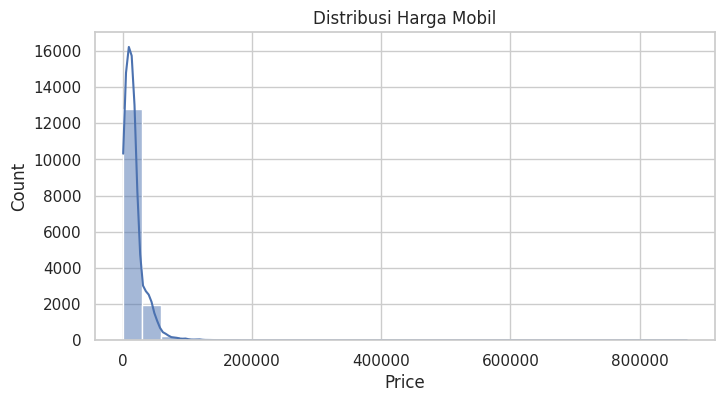

In [ ]:
# Distribusi setelah drop outlier khusus
plt.figure(figsize=(8, 4))
sns.histplot(df_clean['Price'], kde=True, bins=30)
plt.title('Distribusi Harga Mobil')
plt.xlabel('Price')
plt.show()

## 3.8 Define Features

In [ ]:
cat_features = df_clean.select_dtypes(include='object').columns.tolist()
num_features = df_clean.select_dtypes(include=['int64', 'float64']).drop(columns=['Price'], errors='ignore').columns.tolist()

## 3.9 Rare Encoding

In [ ]:
def rare_encoder(df_clean, column, threshold=0.01):
    freq = df_clean[column].value_counts(normalize=True)
    rare_labels = freq[(freq < threshold) & (freq.index != '>5')].index  # kecualikan '>5'
    df_clean[column] = df_clean[column].replace(rare_labels, "Rare")
    return df_clean

for col in cat_features:
    df_clean = rare_encoder(df_clean, col)

In [ ]:
# Tambahkan 'Doors_category' jika belum masuk
if 'Doors_category' not in cat_features:
    cat_features.append('Doors_category')

In [ ]:
for col in cat_features:
    print(f"{col}: {df_clean[col].unique().tolist()}")

Manufacturer: ['LEXUS', 'CHEVROLET', 'HONDA', 'FORD', 'HYUNDAI', 'TOYOTA', 'MERCEDES-BENZ', 'OPEL', 'Rare', 'BMW', 'AUDI', 'NISSAN', 'SUBARU', 'KIA', 'MITSUBISHI', 'SSANGYONG', 'VOLKSWAGEN']
Category: ['Jeep', 'Hatchback', 'Sedan', 'Rare', 'Universal', 'Coupe', 'Minivan']
Drive wheels: ['4x4', 'Front', 'Rear']
fuel_gear: ['Hybrid_Automatic', 'Petrol_Tiptronic', 'Petrol_Variator', 'Petrol_Automatic', 'Diesel_Automatic', 'CNG_Manual', 'Rare', 'CNG_Automatic', 'Hybrid_Tiptronic', 'Hybrid_Variator', 'Petrol_Manual', 'LPG_Automatic', 'Diesel_Manual']
Doors_category: ['4-5', '2-3', '>5']


## 3.10 Variance Threshold

In [ ]:
num_data = df_clean[num_features].replace([np.inf, -np.inf], np.nan)
num_data = num_data.fillna(num_data.median())
vt = VarianceThreshold(threshold=0.1)
vt.fit(num_data)
selected_num_cols = num_data.columns[vt.get_support()].tolist()

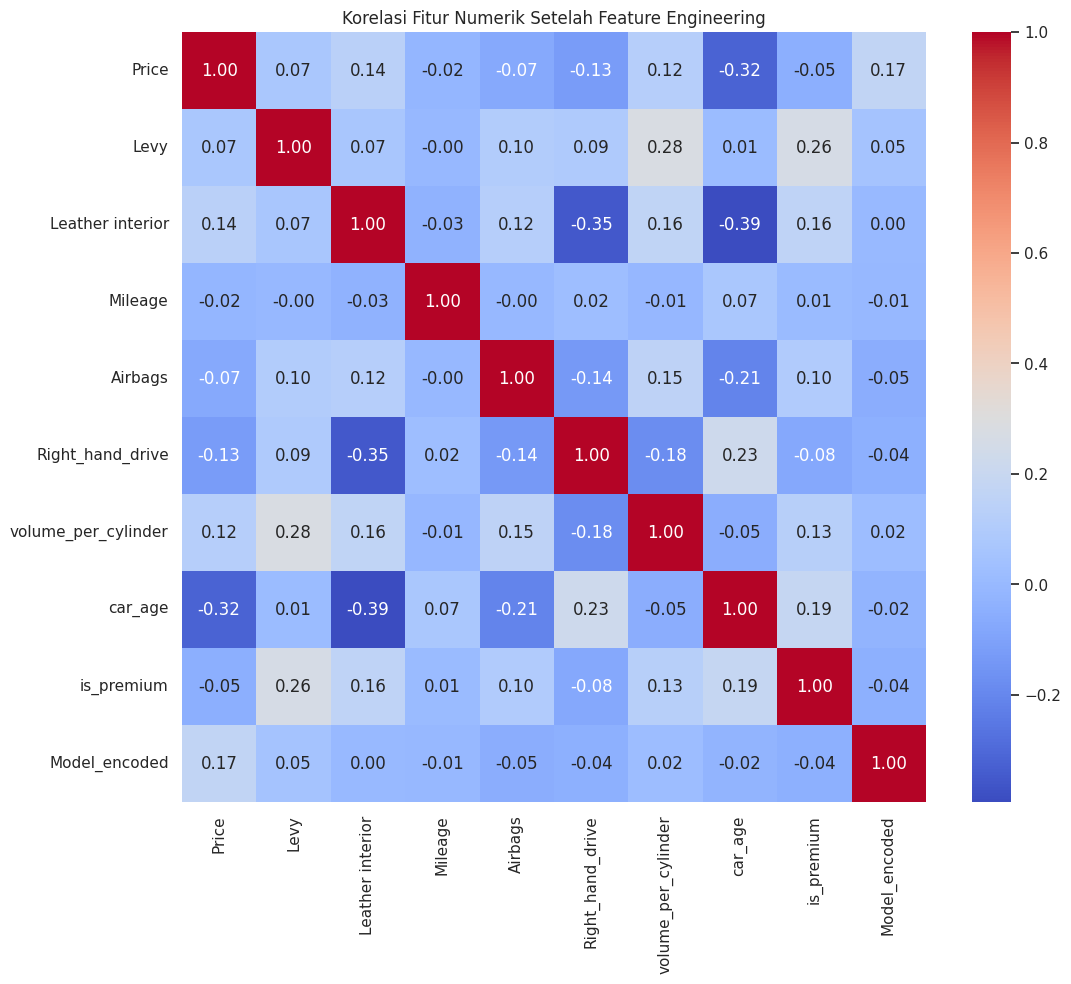

In [ ]:
plt.figure(figsize=(12, 10))
corr = df_clean.select_dtypes(include=np.number).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Korelasi Fitur Numerik Setelah Feature Engineering")
plt.show()

# 4.&nbsp;Split Dataset

In [ ]:
# 1. Ambil fitur numerik dan kategorikal
X = df_clean[selected_num_cols + cat_features]
y_raw = df_clean['Price']                    # Harga asli
y_log = np.log1p(y_raw)                      # Log transform

# 2. Gabungkan untuk cleaning bersama
Xy = pd.concat([X, y_log.rename("Price_log"), y_raw.rename("Price_raw")], axis=1)

# 3. Bersihkan inf dan NaN
Xy.replace([np.inf, -np.inf], np.nan, inplace=True)
Xy.dropna(inplace=True)

# 4. Pisahkan kembali
X = Xy[selected_num_cols + cat_features]
y = Xy['Price_log']
y_raw = Xy['Price_raw']  # Sinkron dengan index X dan y

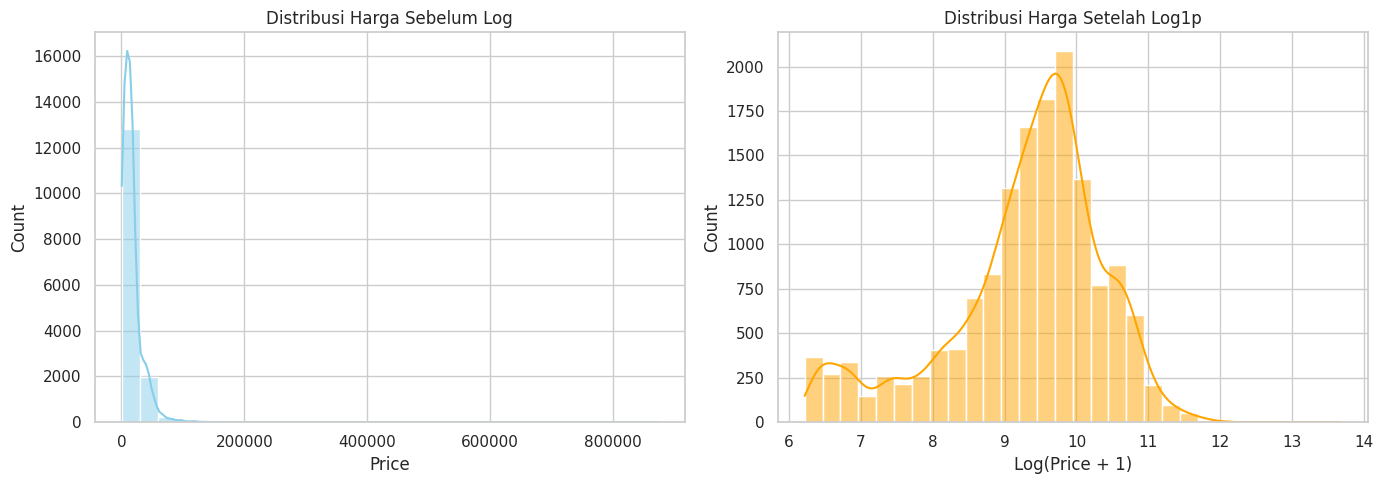

In [ ]:
# 5. Visualisasi distribusi
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(y_raw, kde=True, bins=30, color='skyblue')
plt.title('Distribusi Harga Sebelum Log')
plt.xlabel('Price')

plt.subplot(1, 2, 2)
sns.histplot(y, kde=True, bins=30, color='orange')
plt.title('Distribusi Harga Setelah Log1p')
plt.xlabel('Log(Price + 1)')

plt.tight_layout()
plt.show()

In [ ]:
# 6. Split dataset
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Harga asli untuk evaluasi (expm1 prediksi)
y_train_raw = y_raw.loc[y_train.index]
y_test_raw = y_raw.loc[y_test.index]

# --- CHECK SHAPE (OPTIONAL DEBUG) ---
print("Train shape:", X_train_raw.shape)
print("Test shape :", X_test_raw.shape)

Train shape: (12079, 12)
Test shape : (3020, 12)


In [ ]:
print(X.columns.tolist())

['Levy', 'Leather interior', 'Mileage', 'Airbags', 'car_age', 'is_premium', 'Model_encoded', 'Manufacturer', 'Category', 'Drive wheels', 'fuel_gear', 'Doors_category']


# 5.&nbsp;Preprocessing Pipelines

In [ ]:
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("encoder", OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, selected_num_cols),
    ("cat", categorical_pipeline, cat_features)
])

# 6.&nbsp;Modeling

## 6.1 Untuned Base Models

In [ ]:
base_models = {
    'DecisionTree_Default': DecisionTreeRegressor(random_state=0),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForest_Default': RandomForestRegressor(random_state=0),
    'XGBoost_Default': XGBRegressor(random_state=0),
    'LightGBM_Default': LGBMRegressor(random_state=0),
    'CatBoost_Default': CatBoostRegressor(verbose=0, random_state=0)
}

print("\n--- Untuned Model Performance ---")
for name, model in base_models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train_raw, y_train)

    # Prediksi log scale
    y_train_pred_log = pipe.predict(X_train_raw)
    y_test_pred_log = pipe.predict(X_test_raw)

    # Kembalikan ke scale asli
    y_train_pred = np.expm1(y_train_pred_log)
    y_test_pred = np.expm1(y_test_pred_log)
    y_train_true = np.expm1(y_train)
    y_test_true = np.expm1(y_test)

    # === Evaluasi Train ===
    r2_train = r2_score(y_train_true, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
    mse_train = mean_squared_error(y_train_true, y_train_pred)
    mae_train = mean_absolute_error(y_train_true, y_train_pred)

    # === Evaluasi Test ===
    r2_test = r2_score(y_test_true, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
    mse_test = mean_squared_error(y_test_true, y_test_pred)
    mae_test = mean_absolute_error(y_test_true, y_test_pred)

    # === Untuned Model Performance ===
    print(f"\n{name}")
    print(f"Train: R2 = {r2_train:.4f}, RMSE = {rmse_train:,.2f}, MSE = {mse_train:,.2f}, MAE = {mae_train:,.2f}")
    print(f" Test: R2 = {r2_test:.4f}, RMSE = {rmse_test:,.2f}, MSE = {mse_test:,.2f}, MAE = {mae_test:,.2f}")

    # Simpan model
    joblib.dump(pipe, f"model_{name}.pkl")


--- Untuned Model Performance ---

DecisionTree_Default
Train: R2 = 0.9871, RMSE = 2,030.36, MSE = 4,122,352.57, MAE = 151.74
 Test: R2 = 0.4381, RMSE = 11,914.72, MSE = 141,960,522.95, MAE = 4,886.25

Ridge
Train: R2 = 0.1969, RMSE = 16,034.76, MSE = 257,113,413.11, MAE = 8,694.08
 Test: R2 = 0.2032, RMSE = 14,188.02, MSE = 201,299,785.98, MAE = 8,525.17

Lasso
Train: R2 = -0.1258, RMSE = 18,985.07, MSE = 360,432,770.61, MAE = 10,851.07
 Test: R2 = -0.1507, RMSE = 17,050.55, MSE = 290,721,299.53, MAE = 10,725.13

RandomForest_Default
Train: R2 = 0.8706, RMSE = 6,435.69, MSE = 41,418,090.30, MAE = 1,623.06
 Test: R2 = 0.7498, RMSE = 7,951.11, MSE = 63,220,171.84, MAE = 3,679.62

XGBoost_Default
Train: R2 = 0.8759, RMSE = 6,302.87, MSE = 39,726,193.38, MAE = 3,122.00
 Test: R2 = 0.7062, RMSE = 8,616.08, MSE = 74,236,867.81, MAE = 4,414.68
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003692 seconds.
You can set `force_col_wise=true` to remove t

## 6.2 Decision Tree (Tuned)

In [ ]:
# Model & Parameter Grid
model_dt = DecisionTreeRegressor(random_state=0)
params_dt = {
    "model__max_depth": [None, 10, 20, 30],
    "model__min_samples_split": [2, 4, 6],
    "model__min_samples_leaf": [1, 2, 4]
}

# Pipeline
pipeline_dt = Pipeline([
    ("preprocessor", preprocessor),
    ("model", model_dt)
])

# GridSearchCV
grid_dt = GridSearchCV(
    pipeline_dt,
    params_dt,
    cv=5,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

# Train
grid_dt.fit(X_train_raw, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Levy',
                                                                          'Leather '
                                                                          'interior',
                                                                          'Mileage',
                                                                          'Airbags',
                                                                          'car_age',
                                                                          'is_premium',
                                                                          'Model_encoded']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Manufacturer',
                                                                          'Category',
                                                                          'Drive '
                                                                          'wheels',
                                                                          'fuel_gear',
                                                                          'Doors_category'])])),
                                       ('model',
                                        DecisionTreeRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20, 30],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 4, 6]},
             scoring='r2', verbose=1)

In [ ]:
# === Prediksi di log scale ===
train_pred_log_dt = grid_dt.predict(X_train_raw)
test_pred_log_dt = grid_dt.predict(X_test_raw)

# === Evaluasi di log scale ===
r2_train_log_dt = r2_score(y_train, train_pred_log_dt)
mse_train_log_dt = mean_squared_error(y_train, train_pred_log_dt)
rmse_train_log_dt = np.sqrt(mse_train_log_dt)
mae_train_log_dt = mean_absolute_error(y_train, train_pred_log_dt)

r2_test_log_dt = r2_score(y_test, test_pred_log_dt)
mse_test_log_dt = mean_squared_error(y_test, test_pred_log_dt)
rmse_test_log_dt = np.sqrt(mse_test_log_dt)
mae_test_log_dt = mean_absolute_error(y_test, test_pred_log_dt)

# === Kembalikan ke original scale ===
train_pred_dt = np.expm1(train_pred_log_dt)
test_pred_dt = np.expm1(test_pred_log_dt)
y_train_true = np.expm1(y_train)
y_test_true = np.expm1(y_test)

# === Evaluasi di original scale ===
r2_train_orig_dt = r2_score(y_train_true, train_pred_dt)
mse_train_orig_dt = mean_squared_error(y_train_true, train_pred_dt)
rmse_train_orig_dt = np.sqrt(mse_train_orig_dt)
mae_train_orig_dt = mean_absolute_error(y_train_true, train_pred_dt)

r2_test_orig_dt = r2_score(y_test_true, test_pred_dt)
mse_test_orig_dt = mean_squared_error(y_test_true, test_pred_dt)
rmse_test_orig_dt = np.sqrt(mse_test_orig_dt)
mae_test_orig_dt = mean_absolute_error(y_test_true, test_pred_dt)

# === Print hasil evaluasi ===
print("\n=== Decision Tree Evaluation ===")

print("\n>> Log Scale")
print(f"Train - R²: {r2_train_log_dt:.4f}, RMSE: {rmse_train_log_dt:.4f}, MSE: {mse_train_log_dt:.4f}, MAE: {mae_train_log_dt:.4f}")
print(f"Test  - R²: {r2_test_log_dt:.4f}, RMSE: {rmse_test_log_dt:.4f}, MSE: {mse_test_log_dt:.4f}, MAE: {mae_test_log_dt:.4f}")

print("\n>> Original Price Scale")
print(f"Train - R²: {r2_train_orig_dt:.4f}, RMSE: {rmse_train_orig_dt:,.2f}, MSE: {mse_train_orig_dt:,.2f}, MAE: {mae_train_orig_dt:,.2f}")
print(f"Test  - R²: {r2_test_orig_dt:.4f}, RMSE: {rmse_test_orig_dt:,.2f}, MSE: {mse_test_orig_dt:,.2f}, MAE: {mae_test_orig_dt:,.2f}")


=== Decision Tree Evaluation ===

>> Log Scale
Train - R²: 0.8761, RMSE: 0.3865, MSE: 0.1494, MAE: 0.2121
Test  - R²: 0.6476, RMSE: 0.6531, MSE: 0.4265, MAE: 0.3651

>> Original Price Scale
Train - R²: 0.7474, RMSE: 8,993.61, MSE: 80,885,091.44, MAE: 2,839.21
Test  - R²: 0.6153, RMSE: 9,858.56, MSE: 97,191,231.79, MAE: 4,603.55


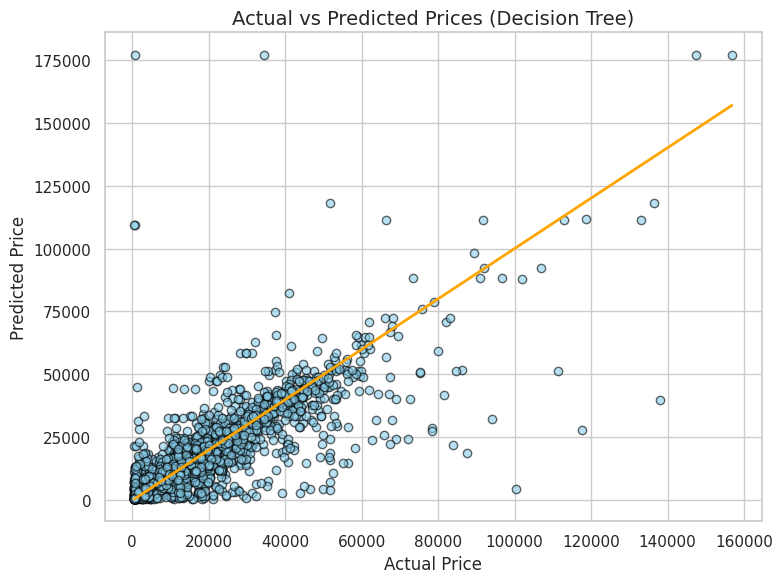

In [ ]:
# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test_raw, test_pred_dt, color='skyblue', edgecolor='black', alpha=0.6)
plt.plot([y_test_raw.min(), y_test_raw.max()], [y_test_raw.min(), y_test_raw.max()], color='orange', lw=2)
plt.title("Actual vs Predicted Prices (Decision Tree)", fontsize=14)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.tight_layout()
plt.show()

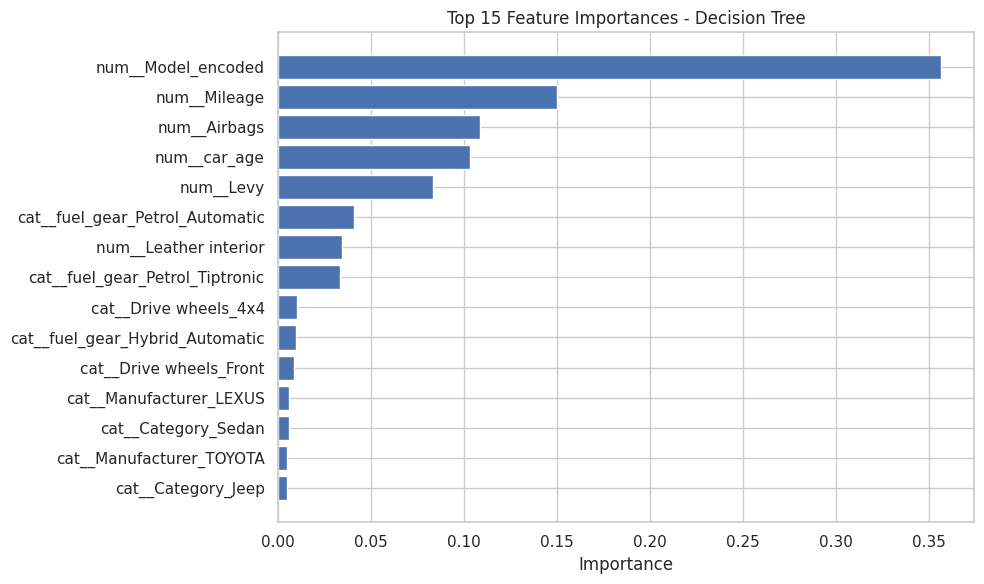

In [ ]:
dt_model = grid_dt.best_estimator_.named_steps['model']
feature_names = grid_dt.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

importance = dt_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances - Decision Tree')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 6.3 Random Forest Regressor (Tuned)

In [ ]:
model_rf = RandomForestRegressor(random_state=0, n_jobs=-1)
params_rf = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [10, 15],
    "model__min_samples_split": [5, 10],
    "model__min_samples_leaf": [5, 10],
    "model__max_features": [0.3, 0.5]
}
pipeline_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", model_rf)
])

grid_rf = GridSearchCV(
    pipeline_rf,
    params_rf,
    cv=5,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

grid_rf.fit(X_train_raw, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Levy',
                                                                          'Leather '
                                                                          'interior',
                                                                          'Mileage',
                                                                          'Airbags',
                                                                          'car_age',
                                                                          'is_premium',
                                                                          'Model_encoded']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Manufacturer',
                                                                          'Category',
                                                                          'Drive '
                                                                          'wheels',
                                                                          'fuel_gear',
                                                                          'Doors_category'])])),
                                       ('model',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=0))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [10, 15],
                         'model__max_features': [0.3, 0.5],
                         'model__min_samples_leaf': [5, 10],
                         'model__min_samples_split': [5, 10],
                         'model__n_estimators': [100, 200]},
             scoring='r2', verbose=1)

In [ ]:
# === Prediksi di log scale ===
train_pred_log_rf = grid_rf.predict(X_train_raw)
test_pred_log_rf = grid_rf.predict(X_test_raw)

# === Evaluasi di log scale ===
r2_train_log_rf = r2_score(y_train, train_pred_log_rf)
mse_train_log_rf = mean_squared_error(y_train, train_pred_log_rf)
rmse_train_log_rf = np.sqrt(mse_train_log_rf)
mae_train_log_rf = mean_absolute_error(y_train, train_pred_log_rf)

r2_test_log_rf = r2_score(y_test, test_pred_log_rf)
mse_test_log_rf = mean_squared_error(y_test, test_pred_log_rf)
rmse_test_log_rf = np.sqrt(mse_test_log_rf)
mae_test_log_rf = mean_absolute_error(y_test, test_pred_log_rf)

# === Kembalikan ke original scale ===
train_pred_rf = np.expm1(train_pred_log_rf)
test_pred_rf = np.expm1(test_pred_log_rf)
y_train_true = np.expm1(y_train)
y_test_true = np.expm1(y_test)

# === Evaluasi di original scale ===
r2_train_orig_rf = r2_score(y_train_true, train_pred_rf)
mse_train_orig_rf = mean_squared_error(y_train_true, train_pred_rf)
rmse_train_orig_rf = np.sqrt(mse_train_orig_rf)
mae_train_orig_rf = mean_absolute_error(y_train_true, train_pred_rf)

r2_test_orig_rf = r2_score(y_test_true, test_pred_rf)
mse_test_orig_rf = mean_squared_error(y_test_true, test_pred_rf)
rmse_test_orig_rf = np.sqrt(mse_test_orig_rf)
mae_test_orig_rf = mean_absolute_error(y_test_true, test_pred_rf)

# === Print hasil evaluasi ===
print("\n=== Random Forest Evaluation ===")

print("\n>> Log Scale")
print(f"Train - R²: {r2_train_log_rf:.4f}, RMSE: {rmse_train_log_rf:.4f}, MSE: {mse_train_log_rf:.4f}, MAE: {mae_train_log_rf:.4f}")
print(f"Test  - R²: {r2_test_log_rf:.4f}, RMSE: {rmse_test_log_rf:.4f}, MSE: {mse_test_log_rf:.4f}, MAE: {mae_test_log_rf:.4f}")

print("\n>> Original Price Scale")
print(f"Train - R²: {r2_train_orig_rf:.4f}, RMSE: {rmse_train_orig_rf:,.2f}, MSE: {mse_train_orig_rf:,.2f}, MAE: {mae_train_orig_rf:,.2f}")
print(f"Test  - R²: {r2_test_orig_rf:.4f}, RMSE: {rmse_test_orig_rf:,.2f}, MSE: {mse_test_orig_rf:,.2f}, MAE: {mae_test_orig_rf:,.2f}")


=== Random Forest Evaluation ===

>> Log Scale
Train - R²: 0.8278, RMSE: 0.4557, MSE: 0.2076, MAE: 0.2810
Test  - R²: 0.7290, RMSE: 0.5727, MSE: 0.3280, MAE: 0.3496

>> Original Price Scale
Train - R²: 0.6492, RMSE: 10,597.04, MSE: 112,297,340.87, MAE: 3,623.27
Test  - R²: 0.7017, RMSE: 8,681.63, MSE: 75,370,656.75, MAE: 4,249.90


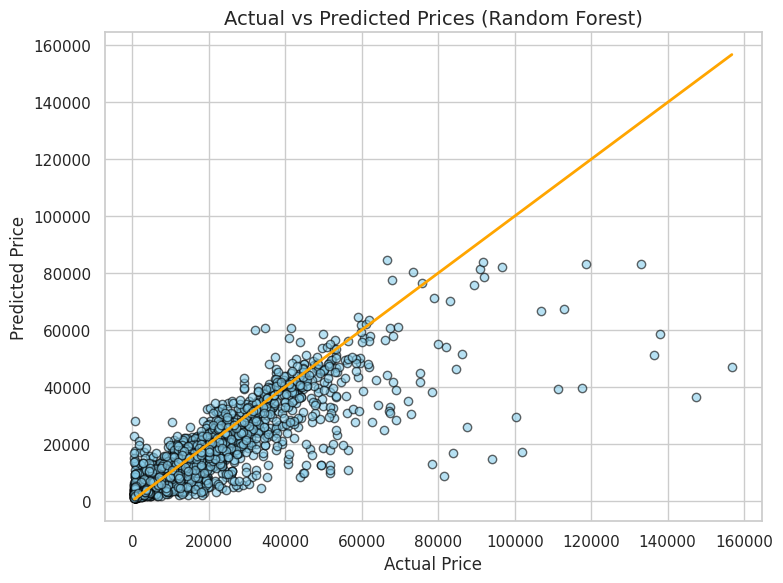

In [ ]:
# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test_raw, test_pred_rf, color='skyblue', edgecolor='black', alpha=0.6)
plt.plot([y_test_raw.min(), y_test_raw.max()], [y_test_raw.min(), y_test_raw.max()], color='orange', lw=2)
plt.title("Actual vs Predicted Prices (Random Forest)", fontsize=14)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.tight_layout()
plt.show()


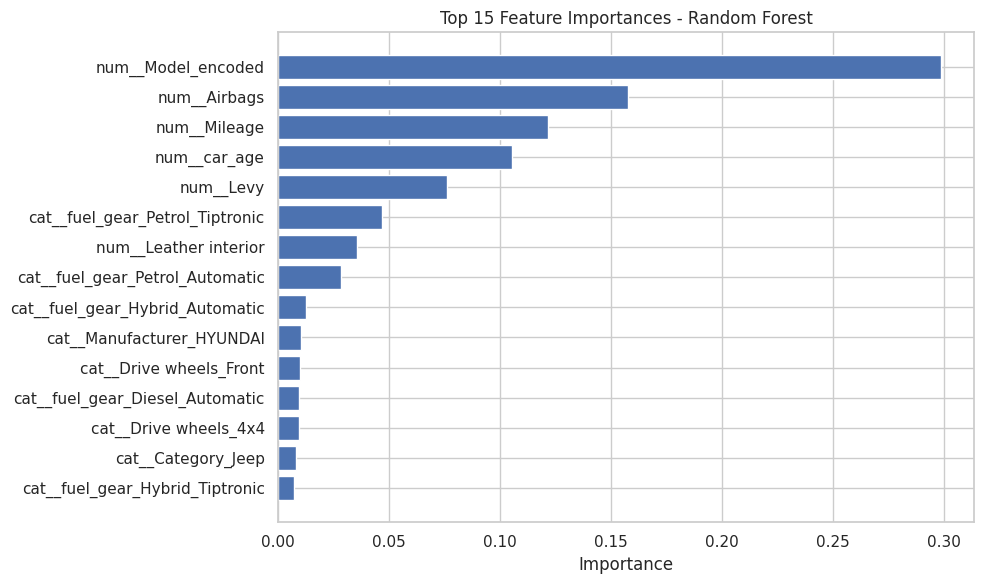

In [ ]:
rf_model = grid_rf.best_estimator_.named_steps['model']
feature_names = grid_rf.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

importance = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 6.4 XGBoost Regressor (Tuned)

In [ ]:
model_xgb = XGBRegressor(random_state=0, n_jobs=-1)
params_xgb = {
    "model__n_estimators": [100, 200],
    "model__learning_rate": [0.01, 0.05],
    "model__max_depth": [3, 5],
    "model__subsample": [0.6, 0.8],
    "model__colsample_bytree": [0.6, 0.8],
    "model__reg_alpha": [0.1, 1.0],
    "model__reg_lambda": [0.1, 1.0]
}
pipeline_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("model", model_xgb)
])

grid_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid=params_xgb,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train_raw, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Levy',
                                                                          'Leather '
                                                                          'interior',
                                                                          'Mileage',
                                                                          'Airbags',
                                                                          'car_age',
                                                                          'is_premium',
                                                                          'Model_encoded']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent...
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=-1,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.6, 0.8],
                         'model__learning_rate': [0.01, 0.05],
                         'model__max_depth': [3, 5],
                         'model__n_estimators': [100, 200],
                         'model__reg_alpha': [0.1, 1.0],
                         'model__reg_lambda': [0.1, 1.0],
                         'model__subsample': [0.6, 0.8]},
             scoring='r2', verbose=1)

In [ ]:
# === Prediksi di log scale ===
train_pred_log_xgb = grid_xgb.predict(X_train_raw)
test_pred_log_xgb = grid_xgb.predict(X_test_raw)

# === Evaluasi di log scale ===
r2_train_log_xgb = r2_score(y_train, train_pred_log_xgb)
mse_train_log_xgb = mean_squared_error(y_train, train_pred_log_xgb)
rmse_train_log_xgb = np.sqrt(mse_train_log_xgb)
mae_train_log_xgb = mean_absolute_error(y_train, train_pred_log_xgb)

r2_test_log_xgb = r2_score(y_test, test_pred_log_xgb)
mse_test_log_xgb = mean_squared_error(y_test, test_pred_log_xgb)
rmse_test_log_xgb = np.sqrt(mse_test_log_xgb)
mae_test_log_xgb = mean_absolute_error(y_test, test_pred_log_xgb)

# === Kembalikan ke original scale ===
train_pred_xgb = np.expm1(train_pred_log_xgb)
test_pred_xgb = np.expm1(test_pred_log_xgb)
y_train_true = np.expm1(y_train)
y_test_true = np.expm1(y_test)

# === Evaluasi di original scale ===
r2_train_orig_xgb = r2_score(y_train_true, train_pred_xgb)
mse_train_orig_xgb = mean_squared_error(y_train_true, train_pred_xgb)
rmse_train_orig_xgb = np.sqrt(mse_train_orig_xgb)
mae_train_orig_xgb = mean_absolute_error(y_train_true, train_pred_xgb)

r2_test_orig_xgb = r2_score(y_test_true, test_pred_xgb)
mse_test_orig_xgb = mean_squared_error(y_test_true, test_pred_xgb)
rmse_test_orig_xgb = np.sqrt(mse_test_orig_xgb)
mae_test_orig_xgb = mean_absolute_error(y_test_true, test_pred_xgb)

# === Print hasil evaluasi ===
print("\n=== XGBoost Evaluation ===")

print("\n>> Log Scale")
print(f"Train - R²: {r2_train_log_xgb:.4f}, RMSE: {rmse_train_log_xgb:.4f}, MSE: {mse_train_log_xgb:.4f}, MAE: {mae_train_log_xgb:.4f}")
print(f"Test  - R²: {r2_test_log_xgb:.4f}, RMSE: {rmse_test_log_xgb:.4f}, MSE: {mse_test_log_xgb:.4f}, MAE: {mae_test_log_xgb:.4f}")

print("\n>> Original Price Scale")
print(f"Train - R²: {r2_train_orig_xgb:.4f}, RMSE: {rmse_train_orig_xgb:,.2f}, MSE: {mse_train_orig_xgb:,.2f}, MAE: {mae_train_orig_xgb:,.2f}")
print(f"Test  - R²: {r2_test_orig_xgb:.4f}, RMSE: {rmse_test_orig_xgb:,.2f}, MSE: {mse_test_orig_xgb:,.2f}, MAE: {mae_test_orig_xgb:,.2f}")


=== XGBoost Evaluation ===

>> Log Scale
Train - R²: 0.7625, RMSE: 0.5351, MSE: 0.2864, MAE: 0.3593
Test  - R²: 0.6930, RMSE: 0.6096, MSE: 0.3716, MAE: 0.3978

>> Original Price Scale
Train - R²: 0.7231, RMSE: 9,415.27, MSE: 88,647,321.00, MAE: 4,516.56
Test  - R²: 0.6891, RMSE: 8,862.87, MSE: 78,550,427.32, MAE: 4,756.17


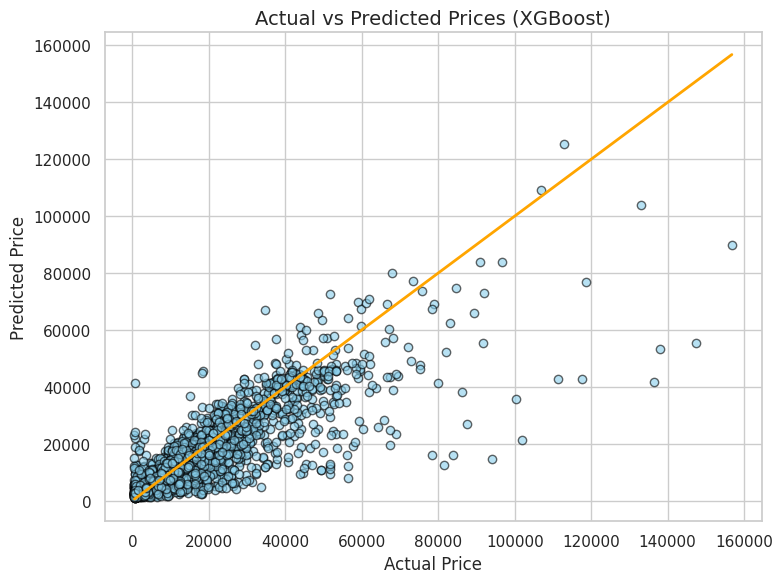

In [ ]:
# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test_raw, test_pred_xgb, color='skyblue', edgecolor='black', alpha=0.6)
plt.plot([y_test_raw.min(), y_test_raw.max()], [y_test_raw.min(), y_test_raw.max()], color='orange', lw=2)
plt.title("Actual vs Predicted Prices (XGBoost)", fontsize=14)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.tight_layout()
plt.show()

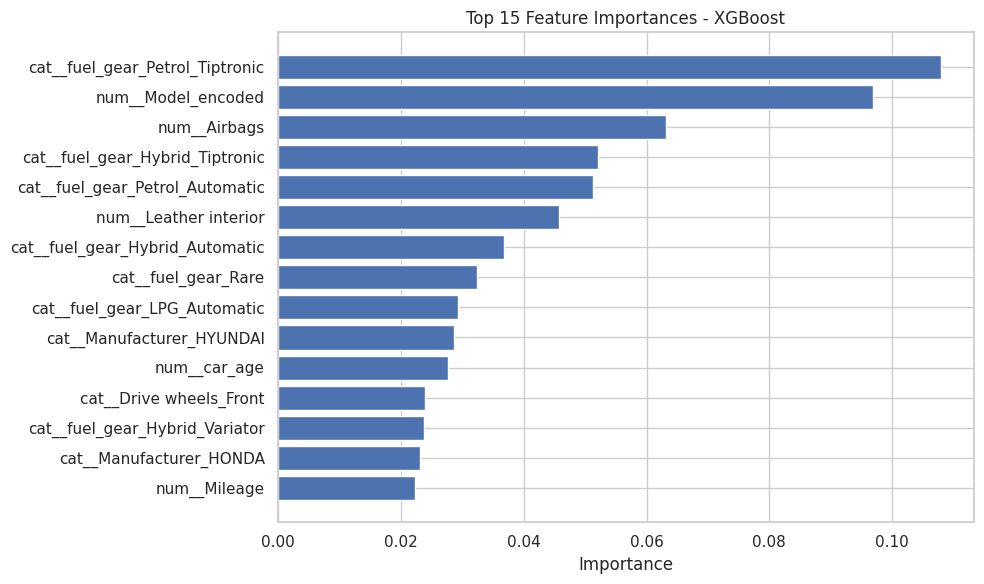

In [ ]:
xgb_model = grid_xgb.best_estimator_.named_steps['model']
feature_names = grid_xgb.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

importance = xgb_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 6.5 LightGBM Regressor (Tuned)

In [ ]:
# Model
model_lgb = LGBMRegressor(random_state=0, n_jobs=-1)

# Hyperparameter space
params_lgb = {
    "model__n_estimators": [100, 300],
    "model__learning_rate": [0.01, 0.05],
    "model__num_leaves": [31, 50],
    "model__min_child_samples": [20, 50],
    "model__reg_alpha": [0.1, 1.0],
    "model__reg_lambda": [0.1, 1.0]
}

# Pipeline
pipeline_lgb = Pipeline([
    ("preprocessor", preprocessor),
    ("model", model_lgb)
])

# GridSearchCV
grid_lgb = GridSearchCV(
    estimator=pipeline_lgb,
    param_grid=params_lgb,
    cv=5,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

# Fit ke data training (yang sudah dilog)
grid_lgb.fit(X_train_raw, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 914
[LightGBM] [Info] Number of data points in the train set: 12079, number of used features: 50
[LightGBM] [Info] Start training from score 9.295474


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Levy',
                                                                          'Leather '
                                                                          'interior',
                                                                          'Mileage',
                                                                          'Airbags',
                                                                          'car_age',
                                                                          'is_premium',
                                                                          'Model_encoded']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent...
                                                                         ['Manufacturer',
                                                                          'Category',
                                                                          'Drive '
                                                                          'wheels',
                                                                          'fuel_gear',
                                                                          'Doors_category'])])),
                                       ('model',
                                        LGBMRegressor(n_jobs=-1,
                                                      random_state=0))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05],
                         'model__min_child_samples': [20, 50],
                         'model__n_estimators': [100, 300],
                         'model__num_leaves': [31, 50],
                         'model__reg_alpha': [0.1, 1.0],
                         'model__reg_lambda': [0.1, 1.0]},
             scoring='r2', verbose=1)

In [ ]:
# === Prediksi di log scale ===
train_pred_log_lgb = grid_lgb.predict(X_train_raw)
test_pred_log_lgb = grid_lgb.predict(X_test_raw)

# === Evaluasi di log scale ===
r2_train_log_lgb = r2_score(y_train, train_pred_log_lgb)
mse_train_log_lgb = mean_squared_error(y_train, train_pred_log_lgb)
rmse_train_log_lgb = np.sqrt(mse_train_log_lgb)
mae_train_log_lgb = mean_absolute_error(y_train, train_pred_log_lgb)

r2_test_log_lgb = r2_score(y_test, test_pred_log_lgb)
mse_test_log_lgb = mean_squared_error(y_test, test_pred_log_lgb)
rmse_test_log_lgb = np.sqrt(mse_test_log_lgb)
mae_test_log_lgb = mean_absolute_error(y_test, test_pred_log_lgb)

# === Kembalikan ke original scale ===
train_pred_lgb = np.expm1(train_pred_log_lgb)
test_pred_lgb = np.expm1(test_pred_log_lgb)
y_train_true = np.expm1(y_train)
y_test_true = np.expm1(y_test)

# === Evaluasi di original scale ===
r2_train_orig_lgb = r2_score(y_train_true, train_pred_lgb)
mse_train_orig_lgb = mean_squared_error(y_train_true, train_pred_lgb)
rmse_train_orig_lgb = np.sqrt(mse_train_orig_lgb)
mae_train_orig_lgb = mean_absolute_error(y_train_true, train_pred_lgb)

r2_test_orig_lgb = r2_score(y_test_true, test_pred_lgb)
mse_test_orig_lgb = mean_squared_error(y_test_true, test_pred_lgb)
rmse_test_orig_lgb = np.sqrt(mse_test_orig_lgb)
mae_test_orig_lgb = mean_absolute_error(y_test_true, test_pred_lgb)

# === Print hasil evaluasi ===
print("\n=== LightGBM Evaluation ===")

print("\n>> Log Scale")
print(f"Train - R²: {r2_train_log_lgb:.4f}, RMSE: {rmse_train_log_lgb:.4f}, MSE: {mse_train_log_lgb:.4f}, MAE: {mae_train_log_lgb:.4f}")
print(f"Test  - R²: {r2_test_log_lgb:.4f}, RMSE: {rmse_test_log_lgb:.4f}, MSE: {mse_test_log_lgb:.4f}, MAE: {mae_test_log_lgb:.4f}")

print("\n>> Original Price Scale")
print(f"Train - R²: {r2_train_orig_lgb:.4f}, RMSE: {rmse_train_orig_lgb:,.2f}, MSE: {mse_train_orig_lgb:,.2f}, MAE: {mae_train_orig_lgb:,.2f}")
print(f"Test  - R²: {r2_test_orig_lgb:.4f}, RMSE: {rmse_test_orig_lgb:,.2f}, MSE: {mse_test_orig_lgb:,.2f}, MAE: {mae_test_orig_lgb:,.2f}")


=== LightGBM Evaluation ===

>> Log Scale
Train - R²: 0.8638, RMSE: 0.4053, MSE: 0.1642, MAE: 0.2592
Test  - R²: 0.7457, RMSE: 0.5548, MSE: 0.3078, MAE: 0.3372

>> Original Price Scale
Train - R²: 0.7657, RMSE: 8,660.65, MSE: 75,006,940.94, MAE: 3,492.19
Test  - R²: 0.7397, RMSE: 8,109.53, MSE: 65,764,436.85, MAE: 4,195.87


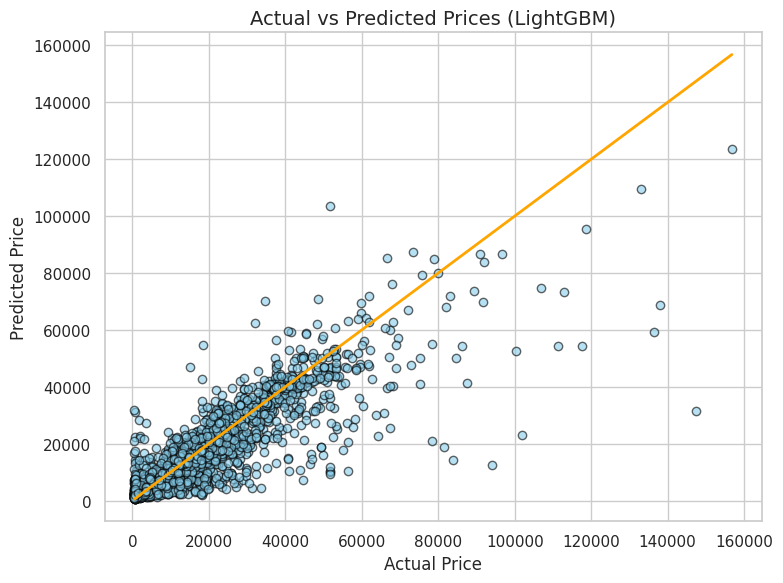

In [ ]:
# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test_raw, test_pred_lgb, color='skyblue', edgecolor='black', alpha=0.6)
plt.plot([y_test_raw.min(), y_test_raw.max()], [y_test_raw.min(), y_test_raw.max()], color='orange', lw=2)
plt.title("Actual vs Predicted Prices (LightGBM)", fontsize=14)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.tight_layout()
plt.show()

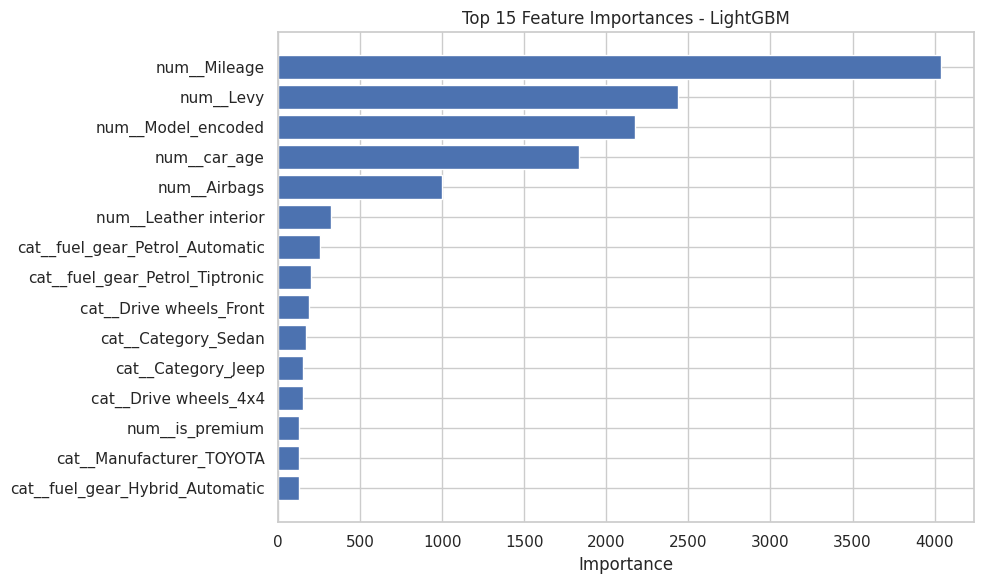

In [ ]:
lgb_model = grid_lgb.best_estimator_.named_steps['model']
feature_names = grid_lgb.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

importance = lgb_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances - LightGBM')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 6.6 Catboost (Tuned)

In [ ]:
# Model
model_cat = CatBoostRegressor(verbose=0, random_state=0)

# Hyperparameter space untuk CatBoost
params_cat = {
    "model__iterations": [500, 800],
    "model__learning_rate": [0.03],         # sedikit lebih cepat dari 0.01
    "model__depth": [6, 8],                 # agak dalam tapi tidak ekstrem
    "model__l2_leaf_reg": [5, 10, 20]       # tidak terlalu kecil, tidak terlalu besar
}

# Pipeline
pipeline_cat = Pipeline([
    ("preprocessor", preprocessor),
    ("model", model_cat)
])

# GridSearchCV
grid_cat = GridSearchCV(
    estimator=pipeline_cat,
    param_grid=params_cat,
    cv=5,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

# Fit ke data training (yang sudah dilog)
grid_cat.fit(X_train_raw, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Levy',
                                                                          'Leather '
                                                                          'interior',
                                                                          'Mileage',
                                                                          'Airbags',
                                                                          'car_age',
                                                                          'is_premium',
                                                                          'Model_encoded']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent...
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Manufacturer',
                                                                          'Category',
                                                                          'Drive '
                                                                          'wheels',
                                                                          'fuel_gear',
                                                                          'Doors_category'])])),
                                       ('model',
                                        <catboost.core.CatBoostRegressor object at 0x7e44a5bf0890>)]),
             n_jobs=-1,
             param_grid={'model__depth': [6, 8],
                         'model__iterations': [500, 800],
                         'model__l2_leaf_reg': [5, 10, 20],
                         'model__learning_rate': [0.03]},
             scoring='r2', verbose=1)

In [ ]:
# === Prediksi di log scale ===
train_pred_log_cat = grid_cat.predict(X_train_raw)
test_pred_log_cat = grid_cat.predict(X_test_raw)

# === Evaluasi di log scale ===
r2_train_log_cat = r2_score(y_train, train_pred_log_cat)
mse_train_log_cat = mean_squared_error(y_train, train_pred_log_cat)
rmse_train_log_cat = np.sqrt(mse_train_log_cat)
mae_train_log_cat = mean_absolute_error(y_train, train_pred_log_cat)

r2_test_log_cat = r2_score(y_test, test_pred_log_cat)
mse_test_log_cat = mean_squared_error(y_test, test_pred_log_cat)
rmse_test_log_cat = np.sqrt(mse_test_log_cat)
mae_test_log_cat = mean_absolute_error(y_test, test_pred_log_cat)

# === Kembalikan ke original scale ===
train_pred_cat = np.expm1(train_pred_log_cat)
test_pred_cat = np.expm1(test_pred_log_cat)
y_train_true = np.expm1(y_train)
y_test_true = np.expm1(y_test)

# === Evaluasi di original scale ===
r2_train_orig_cat = r2_score(y_train_true, train_pred_cat)
mse_train_orig_cat = mean_squared_error(y_train_true, train_pred_cat)
rmse_train_orig_cat = np.sqrt(mse_train_orig_cat)
mae_train_orig_cat = mean_absolute_error(y_train_true, train_pred_cat)

r2_test_orig_cat = r2_score(y_test_true, test_pred_cat)
mse_test_orig_cat = mean_squared_error(y_test_true, test_pred_cat)
rmse_test_orig_cat = np.sqrt(mse_test_orig_cat)
mae_test_orig_cat = mean_absolute_error(y_test_true, test_pred_cat)

# === Print hasil evaluasi ===
print("\n=== CatBoost Evaluation ===")

print("\n>> Log Scale")
print(f"Train - R²: {r2_train_log_cat:.4f}, RMSE: {rmse_train_log_cat:.4f}, MSE: {mse_train_log_cat:.4f}, MAE: {mae_train_log_cat:.4f}")
print(f"Test  - R²: {r2_test_log_cat:.4f}, RMSE: {rmse_test_log_cat:.4f}, MSE: {mse_test_log_cat:.4f}, MAE: {mae_test_log_cat:.4f}")

print("\n>> Original Price Scale")
print(f"Train - R²: {r2_train_orig_cat:.4f}, RMSE: {rmse_train_orig_cat:,.2f}, MSE: {mse_train_orig_cat:,.2f}, MAE: {mae_train_orig_cat:,.2f}")
print(f"Test  - R²: {r2_test_orig_cat:.4f}, RMSE: {rmse_test_orig_cat:,.2f}, MSE: {mse_test_orig_cat:,.2f}, MAE: {mae_test_orig_cat:,.2f}")


=== CatBoost Evaluation ===

>> Log Scale
Train - R²: 0.8093, RMSE: 0.4795, MSE: 0.2299, MAE: 0.3145
Test  - R²: 0.7233, RMSE: 0.5787, MSE: 0.3349, MAE: 0.3671

>> Original Price Scale
Train - R²: 0.7984, RMSE: 8,033.61, MSE: 64,538,820.47, MAE: 3,982.54
Test  - R²: 0.7356, RMSE: 8,173.18, MSE: 66,800,949.75, MAE: 4,428.50


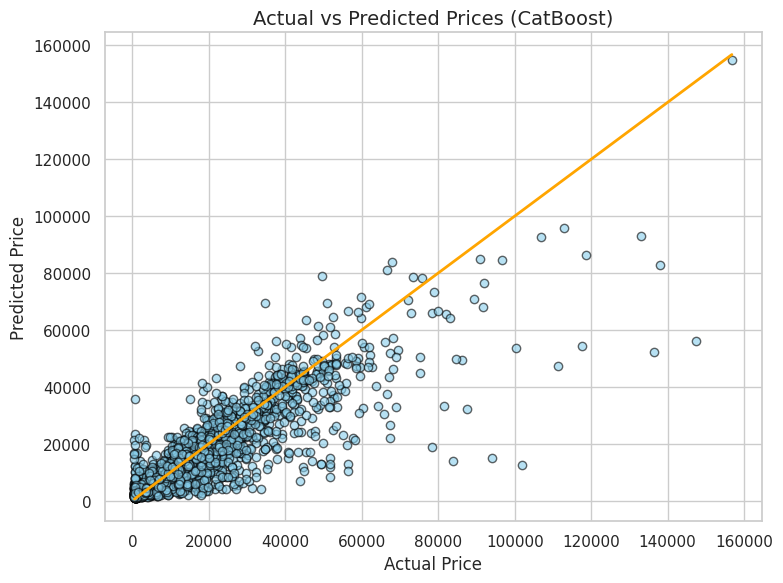

In [ ]:
# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test_raw, test_pred_cat, color='skyblue', edgecolor='black', alpha=0.6)
plt.plot([y_test_raw.min(), y_test_raw.max()], [y_test_raw.min(), y_test_raw.max()], color='orange', lw=2)
plt.title("Actual vs Predicted Prices (CatBoost)", fontsize=14)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.tight_layout()
plt.show()

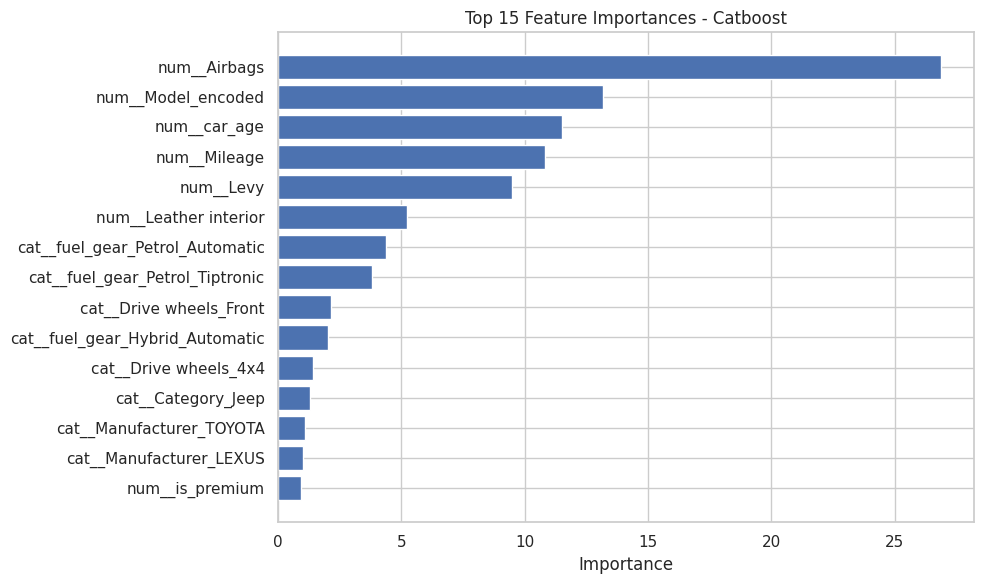

In [ ]:
cat_model = grid_cat.best_estimator_.named_steps['model']
feature_names = grid_cat.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

importance = cat_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances - Catboost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 7.&nbsp;Evaluation

In [ ]:
# List untuk menyimpan hasil
results = []

# Fungsi untuk menilai apakah R² valid (>= 0)
def is_valid(r2_test):
    return r2_test >= 0

# Fungsi evaluasi model
def evaluate_model(name, model, tuned=False, is_pipeline=True):
    if is_pipeline:
        model = Pipeline([
            ("preprocessor", preprocessor),
            ("model", model)
        ])
        model.fit(X_train_raw, y_train)

    # Prediksi test set
    y_pred_log = model.predict(X_test_raw)
    y_pred_original = np.expm1(y_pred_log)

    # Prediksi train set
    y_train_pred_log = model.predict(X_train_raw)
    y_train_pred_original = np.expm1(y_train_pred_log)

    # Hitung metrik
    r2_train = r2_score(y_train_raw, y_train_pred_original)
    r2_test = r2_score(y_test_raw, y_pred_original)
    rmse_test = np.sqrt(mean_squared_error(y_test_raw, y_pred_original))
    mse_test = mean_squared_error(y_test_raw, y_pred_original)
    mae_test = mean_absolute_error(y_test_raw, y_pred_original)

    results.append({
        "Model": name,
        "Tuned": "Yes" if tuned else "No",
        "R2_Train": r2_train,
        "R2_Test": r2_test,
        "OverfitGap": abs(r2_train - r2_test),
        "RMSE": rmse_test,
        "MSE": mse_test,
        "MAE": mae_test,
        "ModelObj": model,
        "ValidModel": is_valid(r2_test)
    })

# === Evaluasi untuned models ===
for name, model in base_models.items():
    evaluate_model(name, model, tuned=False, is_pipeline=True)

# === Evaluasi tuned models ===
tuned_models = [
    ("DecisionTree", grid_dt),
    ("RandomForest", grid_rf),
    ("XGBoost", grid_xgb),
    ("LightGBM", grid_lgb),
    ("Catboost", grid_cat)
]
for name, model in tuned_models:
    evaluate_model(name, model, tuned=True, is_pipeline=False)

# Konversi ke DataFrame
results_df = pd.DataFrame(results)

# Pisahkan valid & invalid
valid_df = results_df[results_df["ValidModel"]]
invalid_df = results_df[~results_df["ValidModel"]]

# Pilih model terbaik: R² Test terbesar → OverfitGap terkecil
best_row = valid_df.sort_values(by=["R2_Test", "OverfitGap"], ascending=[False, True]).iloc[0]
best_model = best_row["ModelObj"]
best_name = best_row["Model"]

# Simpan model terbaik
joblib.dump(best_model, f"best_model_{best_name}.pkl")

# Gabungkan untuk tabel akhir
final_df = pd.concat([valid_df, invalid_df], ignore_index=True)

# Urutkan tabel akhir (utamakan R² positif → R² Test besar → Gap kecil)
final_df_sorted = final_df.assign(IsNegativeR2=final_df["R2_Test"] < 0).sort_values(
    by=["IsNegativeR2", "R2_Test", "OverfitGap"],
    ascending=[True, False, True]
).drop(columns=["ModelObj", "ValidModel", "IsNegativeR2"]).reset_index(drop=True)

# Tampilkan hasil
print("\nRingkasan Evaluasi Model (Lengkap):\n")
display(final_df_sorted)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 914
[LightGBM] [Info] Number of data points in the train set: 12079, number of used features: 50
[LightGBM] [Info] Start training from score 9.295474

Ringkasan Evaluasi Model (Lengkap):



,Model,Tuned,R2_Train,R2_Test,OverfitGap,RMSE,MSE,MAE
0,RandomForest_Default,No,0.870630,0.749773,0.120857,7951.111359,6.322017e+07,3679.616467
1,LightGBM,Yes,0.765714,0.739702,0.026012,8109.527535,6.576444e+07,4195.871495
2,Catboost,Yes,0.798412,0.735600,0.062812,8173.184799,6.680095e+07,4428.504242
3,CatBoost_Default,No,0.824026,0.726211,0.097815,8317.031900,6.917302e+07,4367.293195
4,LightGBM_Default,No,0.670030,0.713106,0.043077,8513.753095,7.248399e+07,4600.513512
5,XGBoost_Default,No,0.875914,0.706168,0.169746,8616.082172,7.423687e+07,4414.680664
6,RandomForest,Yes,0.649237,0.701681,0.052444,8681.627541,7.537066e+07,4249.903736
7,XGBoost,Yes,0.723108,0.689095,0.034013,8862.867707,7.855042e+07,4756.169434
8,DecisionTree,Yes,0.747354,0.615314,0.132040,9858.561345,9.719123e+07,4603.552768
9,DecisionTree_Default,No,0.987124,0.438116,0.549008,11914.718752,1.419605e+08,4886.247146


# 8.&nbsp;Save Model

In [ ]:
# Ambil hasil terbaik dari GridSearchCV yang sudah fit
best_model = grid_lgb.best_estimator_

# Simpan pipeline penuh (sudah termasuk preprocessor + best model)
joblib.dump(best_model, 'best_model_LightGBM.pkl')

['best_model_LightGBM.pkl']